# Transformer
Transformer is completely based on the attention mechanism, without using CNN or RNN. It used in the seq2seq tasks in text data, but have been widely used in many DL tasks, such as language, visual and audio.
It is a classic encoder-decoder architecture, which has been shown in the fig below. Compared with seq2seq model we implemented by using Bahdanau attention in section10.4, Transformer's encoder and decoder is stacked by layers of self-attention modules. Origin input sequence and output embedding sequence will add with positional encoding, then put them into encoder and decoder.
![transformer](../statics/imgs/section10.7_fig1.jpg)
Generally, fig above shows that the encoder of Transformer is consists of many layers with same structure, and each layer owns 2 sublayer. First sublayer is multi-head self-attention pooling, and second sublayer is positionwise feed-forward network. To be concisely, when we execute self-attention calculations in encoder, query, key and value are come from the output of the former encoder layer. In addition, each sublayer uses residual connection.
Decoder also stacked with many same layers, and uses residual and layer normalization in the layer as well. Expect from two sublayer we described in the encoder, the third sublayer is inserted into the sublayer as well, which we called encoder-decoder attention layer. In encoder-decoder attention, query comes from the output from the last decoder layer. However, each position in decoder can only consider every position before current position. This type of masked attention keeps attributes of auto-regressive, and make sure the prediction only depends on those generated output tokens.

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd

In [2]:
# position-wise feed-forward network
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.4256, -0.0439, -0.2478,  0.1027,  0.3032, -0.6424, -0.0154, -0.6512],
        [ 0.4256, -0.0439, -0.2478,  0.1027,  0.3032, -0.6424, -0.0154, -0.6512],
        [ 0.4256, -0.0439, -0.2478,  0.1027,  0.3032, -0.6424, -0.0154, -0.6512]],
       grad_fn=<SelectBackward0>)

In [4]:
# residual & normalization
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        # layernorm after residual
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [7]:
# encoder
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size,
                                                num_hiddens, num_heads, dropout, use_bias)
        self.addNorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addNorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addNorm1(X, self.attention(X, X, X, valid_lens))
        return self.addNorm2(Y, self.ffn(Y))

In [8]:
# any layer of encoder will not change the shape of input
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [9]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout,
                 use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,ffn_num_input,
                                              ffn_num_hiddens, num_heads, dropout, use_bias))
    def forward(self, X, valid_lens, *args):
        # as positional encoding is between -1 and 1, so embedding values have to be scaled, then adds with positional code
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addNorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addNorm2): AddNorm(
        (d

In [11]:
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [14]:
# decoder
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addNorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addNorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addNorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # training stage, each token in the output sequence are processed at same time. So state[2][self.i] will be None
        # evaluation stage, they are decodes one token by another token, so state[2][self.i] contains i-th block's output representation up to current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addNorm1(X, X2)
        # encoder-decoder attention
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addNorm2(Y, Y2)
        return self.addNorm3(Z, self.ffn(Z)), state

In [15]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [16]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layer = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layer]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [17]:
# training
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, 'cuda'
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)

In [18]:
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)

loss 0.032, 5314.8 tokens/sec on cuda


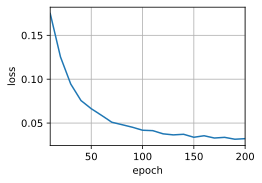

In [19]:
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} -> {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . -> va !, bleu 1.000
i lost . -> j'ai perdu ., bleu 1.000
he's calm . -> il est mouillé ., bleu 0.658
i'm home . -> je suis chez moi ., bleu 1.000


In [22]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

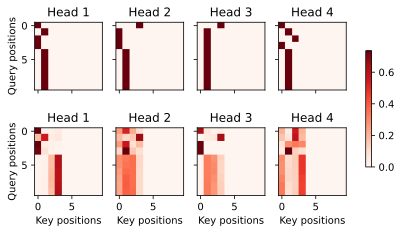

In [23]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [24]:
# to visualize decoder's self-attention and encoder-decoder's attention weights, we have to finish more data operation
# works, like use zero to fill those masked weights. Both of them have the same query, which is <bos> at the first,
# and form a sequence with the following tokens
dec_attention_weights_2d = [head[0].tolist() for step in attention_weight_seq for attn
                            in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attenion_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attenion_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

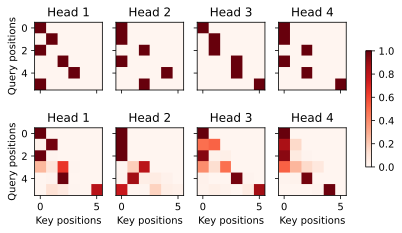

In [25]:
# because the self-regressive attribute of self-attention, query won't calculate attention of kv pairs after current position
d2l.show_heatmaps(dec_self_attenion_weights[:, :, :, :len(translation.split()) + 1],
                  xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

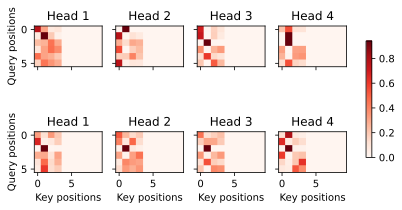

In [26]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))